In [45]:
import numpy as np
import matplotlib.pyplot as plt

from utils import smooth, system_matrix_1d
from fem_assembly import assembly_1d

In [46]:
def restrict(x, sparse=False):
    """Applies the restriction operator to vector x. 

    Parameters
    ----------
    x : numpy.array
        vector on finer grid

    Returns
    ------- 
    numpy.array
        vector on coarse grid
    """
    n = x.shape[0]
    nr = int((n-1)/2)
    R = np.zeros((nr, n))
    R[:,0] = 0.25
    R[:,1] = 0.50
    R[:,2] = 0.25

    # Roll rows of R
    r = np.arange(0, 2*R.shape[0], 2)
    rows, column_indices = np.ogrid[:R.shape[0], :R.shape[1]]
    r[r < 0] += R.shape[1]
    column_indices = column_indices - r[:, np.newaxis]
    R = R[rows, column_indices]
    x_restricted =  np.matmul(R, x)

    return x_restricted

In [47]:
def interpolate(x, sparse=False):
    """Applies the interpolation operator to vector x

    Parameters
    ----------
    x : numpy.array
        vector on coarse grid

    Returns
    ------- 
    numpy.array
        vector on fine grid
    """
    # Pad with zeros
    x_padded = np.concatenate(([0], x, [0]))
    ni = 2*x.shape[0]+1
    I = np.zeros((ni, x_padded.shape[0]))
    I[::2,0:2] = [0.5, 0.5]
    I[1::2,0] = 1

    # Roll rows of I
    r = np.zeros(I.shape[0]+1)
    r[::2] = np.arange((r.shape[0])/2)
    r[1::2] = np.arange(r.shape[0]/2)
    r = r[1:]

    for k in range(r.shape[0]):
        I[k,:] = np.roll(I[k,:], int(r[k]))

    return np.matmul(I, x_padded)

In [54]:
def P(i, f):
    """Generate the problem for 1-dimensional discrete Poisson equation

    Parameters
    ----------
    i : int
        Number of unknowns will be 2**i - 1
        
    f : function
        The load function

    Returns
    -------
    numpy.array
        System matrix  
    numpy.array
        right-hand side
    numpy.array
        grid
    """
    number_of_points = 2**i + 1
    t = np.linspace(0, 1, number_of_points)
    
    # Generate 1D mesh
    n = np.arange(t.shape[0])
    n1 = n[0:n.shape[0]-1]
    n2 = n[1:]
    e = np.transpose(np.vstack((n1, n2)))
    
    A, b = assembly_1d(f, t, e)
    
    # Remove boundary nodes
    N = A.shape[0]
    A = A[1:(N-1), 1:(N-1)]
    b = b[1:(N-1)]
    
    return A, b, t[1:-1]
    # T = system_matrix_1d(i)
    # b = f(t[1:-1])
    # return T, b, t[1:-1]

In [101]:
# Multigrid V-cycle
def MGV(b, x, i, sn=1):
    """Recursive Multigrid V-cycle algorithm

    Parameters
    ----------
    b_i : numpy.array
        right-hand side of problem P(i), fine grid
        
    x_i : numpy.array
        approximate solution of problem P(i), fine grid
    sn : int
        number of times smoothing operator is applied on each iteration

    Returns
    -------
    numpy.array
        solution to the problem P(i)
    """
    T = system_matrix_1d(i)
    
    if i == 1:
        print("MGV called with i = 1")
        x = np.linalg.solve(T, b)
        return x
    else:
        print("MGV called with i = ", i)
        # Smoothen the approximate solution
        for _ in range(sn):
            x = smooth(x=x, A=T, b=b)
        
        # Calculate residual
        r = np.dot(T, x) - b
        
        # Restrict the residual to coarser grid
        r = restrict(x=r)
        
        # Solve the correction term d, initial guess at 0
        x0 = np.zeros_like(r)
        d = MGV(b=r, x=x0, i=i-1)
        
        # Interpolate to finer grid
        d = interpolate(d)
        
        # Make the correction and smoothen some more
        x = x - d
        for _ in range(sn):
            x = smooth(x=x, A=T, b=b)
        #x = smooth(x=x, A=T, b=b)
        return x
    

# Full Multigrid
def FMG(f, m, sn):
    T, b, t = P(1, f)
    x = np.linalg.solve(T, b)
    xs = []
    bs = []
    ts = []
    xs.append(x)
    bs.append(b)
    ts.append(t)
    for i in range(2, m):
        x_in = interpolate(x)
        _, _, t_in = P(i, f)
        b_in = f(t_in)
        x = MGV(b_in, x_in, i, sn)
        xs.append(x)
        bs.append(b_in)
        ts.append(t_in)
    return xs, bs, ts

In [102]:
def f(t):
    return np.ones_like(t) * 8

u = lambda t: -4*t**2+4*t
    

In [103]:
class PoissonProblem1D:
    """Class for solving 1D poisson problem with multigrid method
    
    Parameters
    ----------
    f : function
        load function
    x0 : int
        lower boundary
    x1 : int
        upper boundary
    u : function
    """
    def __init__(self, f, x0 = 0.0, x1 = 1.0, u = None):
        self.f = f
        self.x0 = x0
        self.x1 = x1
        self.u = u
        
        self.xs = None
        self.bs = None
        self.ts = None
        
    def solve_fmg(self, m, sn):
        """Solves 1D Poisson problem with full multigrid method
        
        Parameters
        ----------
        m : int
            Number of gridpoints n = 2**m+1
            
        sn : int
            Number of times smoothing operator is applied on each iteration
        """
        self.xs, self.bs, self.ts = FMG(f=self.f, m=m, sn=sn)
        
    def plot_correct_solution(self):
        """Plots the correct solution to the problem.
        """
        plt.figure()
        plt.plot(self.ts[-1], self.u(self.ts[-1]))
    
    def plot_fmg_solution(self):
        """Plots the solved fmg solution
        """
        plt.figure()
        plt.plot(self.ts[-1], self.xs[-1])
        
    def plot_fmg_solution_error(self):
        """Plots the error of fmg solution
        """
        plt.figure()
        plt.plot(self.ts[-1], self.xs[-1] - self.u(self.ts[-1]))

In [104]:
x0 = 0.0
x1 = 1.0
poisson = PoissonProblem1D(x0=0.0, x1=1.0, f=f, u=u)

In [123]:
poisson.solve_fmg(5, sn=5)

3
[0. 0. 0.]
5
[0. 0. 0. 0. 0.]
MGV called with i =  2
MGV called with i = 1
9
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
MGV called with i =  3
MGV called with i =  2
MGV called with i = 1
17
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
MGV called with i =  4
MGV called with i =  3
MGV called with i =  2
MGV called with i = 1


# Solutions

In [124]:
poisson.xs

[array([1.]),
 array([0.74791698, 0.99705329, 0.74791698]),
 array([0.43626819, 0.74772129, 0.93452658, 0.99677775, 0.93452658,
        0.74772129, 0.43626819]),
 array([0.23400972, 0.43682299, 0.60847336, 0.7489604 , 0.85826217,
        0.93634782, 0.98320162, 0.99881876, 0.98320162, 0.93634782,
        0.85826217, 0.7489604 , 0.60847336, 0.43682299, 0.23400972])]

# Grids

In [125]:
poisson.ts

[array([0.5]),
 array([0.25, 0.5 , 0.75]),
 array([0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875]),
 array([0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375, 0.5   ,
        0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375])]

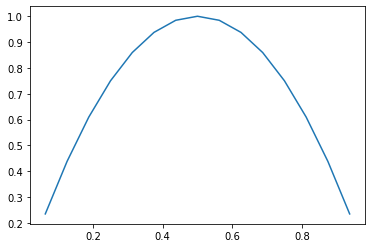

In [126]:
poisson.plot_correct_solution()

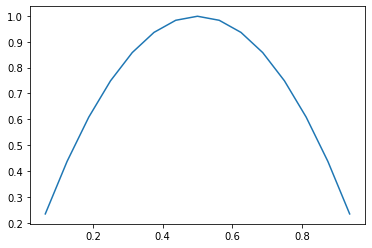

In [127]:
poisson.plot_fmg_solution()

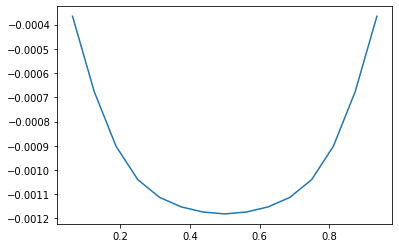

In [128]:
poisson.plot_fmg_solution_error()